In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Load raw data

In [43]:
df = pd.read_csv('../tmp/matched_sequences.csv', header=0, index_col=0)
df.head()

,Seq,Class
1667874818,P0P0P0P0E2T0G1P0P0P0P0P0P0G0T0G0T2G0T0T0G1G0T4...,1
893140995,P0P0P2P0P0P2T0T0G0G2G0T0P0P0P0P1I0G0T2P0P0P0E0...,1
8189009928,T0G3G0T1P0P0T0T0T0S0S0S0S0T0T0G2T0G3G0T0P0P0P0...,1
4599996427,I0T0O2T0I3G0T0T0G3G0T2G0T3G0T2O2G0T0P0P0P0P0P1...,1
6111690766,G2O0P0P0P0P2G0P0P0P2G0T2T3G0I0G1G3G1T0E0P0S0P0...,1


# Seq2Tokens

In [44]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=True, lower=False, split='')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['Seq'])
n_feat = len(tokenizer.word_index.keys())
seq = tokenizer.texts_to_sequences(df['Seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 90))
p_seq = pad_sequences(seq, maxlen=maxlen)

# Training - Validation - Test split

In [45]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

28806 learn / 28806 test
25925 training / 2881 validation


# Model \#1: Embedding + Dense (good baseline)

In [150]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
flatten_6 (Flatten)          (None, 59584)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 59585     
Total params: 60,673
Trainable params: 60,673
Non-trainable params: 0
_________________________________________________________________


In [151]:
callbacks = [EarlyStopping(monitor='val_loss', patience=30)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/500
25925/25925 [==============================] - 3s 124us/step - loss: 0.4659 - acc: 0.7750 - val_loss: 0.3308 - val_acc: 0.8601
Epoch 2/500
25925/25925 [==============================] - 2s 75us/step - loss: 0.3147 - acc: 0.8673 - val_loss: 0.3350 - val_acc: 0.8605
Epoch 3/500
25925/25925 [==============================] - 2s 77us/step - loss: 0.2890 - acc: 0.8796 - val_loss: 0.2883 - val_acc: 0.8778
Epoch 4/500
25925/25925 [==============================] - 2s 76us/step - loss: 0.2751 - acc: 0.8876 - val_loss: 0.3187 - val_acc: 0.8657
Epoch 5/500
25925/25925 [==============================] - 2s 77us/step - loss: 0.2630 - acc: 0.8926 - val_loss: 0.3678 - val_acc: 0.8542
Epoch 6/500
25925/25925 [==============================] - 2s 76us/step - loss: 0.2527 - acc: 0.8980 - val_loss: 0.3433 - val_acc: 0.8549
Epoch 7/500
25925/25925 [==============================] - 2s 77us/step - loss: 0.2464 - acc: 0.9011 - val_loss: 0.3266 - 

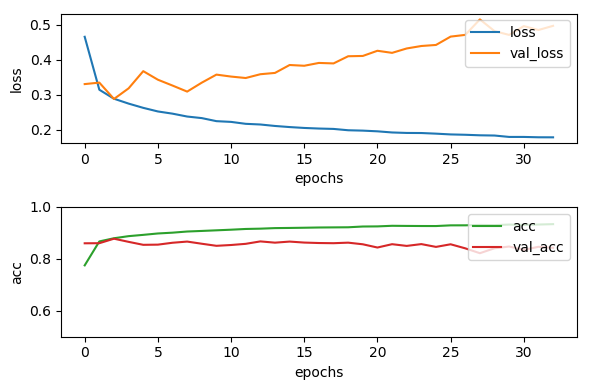

In [152]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('embedding_dense.png')

In [153]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

28806/28806 [==============================] - 3s 103us/step
test_loss: 0.5299 - test_acc: 0.8427


In [154]:
model.save_weights('embedding_dense.h5')

# Model \#2: Embedding + SimpleRNN (not working in our case)

In [97]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.6172 - acc: 0.6586 - val_loss: 0.5976 - val_acc: 0.6800
Epoch 2/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.5764 - acc: 0.7028 - val_loss: 0.5748 - val_acc: 0.7067
Epoch 3/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.6028 - acc: 0.6763 - val_loss: 0.5817 - val_acc: 0.7081
Epoch 4/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.5738 - acc: 0.7091 - val_loss: 0.5244 - val_acc: 0.7466
Epoch 5/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.5532 - acc: 0.7186 - val_loss: 0.5510 - val_acc: 0.7289
Epoch 6/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.5849 - acc: 0.6923 - val_loss: 0.5453 - val_acc: 0.7098
Epoch 7/30
25925/25925 [==============================] - 64s 2ms/step - loss: 0.5809 - acc: 0.7050 - val_loss: 0.5819 - val_acc:

KeyboardInterrupt: 

# Model \#3: Embedding + LSTM (seems good for our case)

In [103]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 13,665
Trainable params: 13,665
Non-trainable params: 0
_________________________________________________________________


In [104]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/30
25925/25925 [==============================] - 22s 830us/step - loss: 0.6227 - acc: 0.6512 - val_loss: 0.6457 - val_acc: 0.6237
Epoch 2/30
25925/25925 [==============================] - 21s 811us/step - loss: 0.5623 - acc: 0.7148 - val_loss: 0.5112 - val_acc: 0.7605
Epoch 3/30
25925/25925 [==============================] - 21s 812us/step - loss: 0.5159 - acc: 0.7526 - val_loss: 0.4822 - val_acc: 0.7692
Epoch 4/30
25925/25925 [==============================] - 21s 829us/step - loss: 0.5188 - acc: 0.7478 - val_loss: 0.4192 - val_acc: 0.8171
Epoch 5/30
25925/25925 [==============================] - 22s 849us/step - loss: 0.5463 - acc: 0.7283 - val_loss: 0.5856 - val_acc: 0.6977
Epoch 6/30
25925/25925 [==============================] - 22s 848us/step - loss: 0.5194 - acc: 0.7527 - val_loss: 0.4807 - val_acc: 0.7848
Epoch 7/30
25925/25925 [==============================] - 22s 853us/step - loss: 0.4156 - acc: 0.8172 - val_loss: 0.3

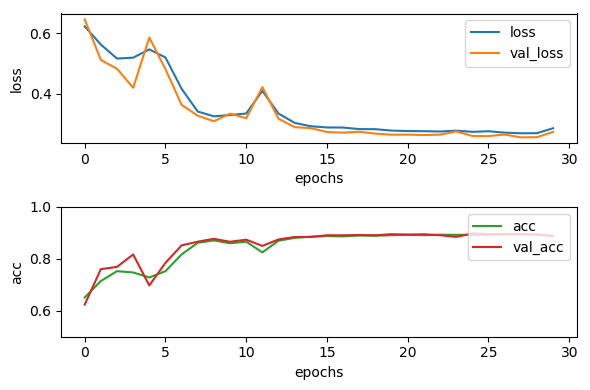

In [105]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

# Model \#4: Embedding + Conv1D + LSTM (basically the same as before)

In [113]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 927, 64)           20544     
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/30
25925/25925 [==============================] - 28s 1ms/step - loss: 0.6040 - acc: 0.6682 - val_loss: 0.4600 - val_acc: 0.8067
Epoch 2/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.4844 - acc: 0.7754 - val_loss: 0.4954 - val_acc: 0.7671
Epoch 3/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.4374 - acc: 0.8085 - val_loss: 0.3686 - val_acc: 0.8386
Epoch 4/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.3710 - acc: 0.8447 - val_loss: 0.3167 - val_acc: 0.8761
Epoch 5/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.3677 - acc: 0.8503 - val_loss: 0.3369 - val_acc: 0.8757
Epoch 6/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.3344 - acc: 0.8634 - val_loss: 0.4743 - val_acc: 0.7803
Epoch 7/30
25925/25925 [==============================] - 26s 1ms/step - loss: 0.3213 - acc: 0.8697 - val_loss: 0.3511 - val_acc:

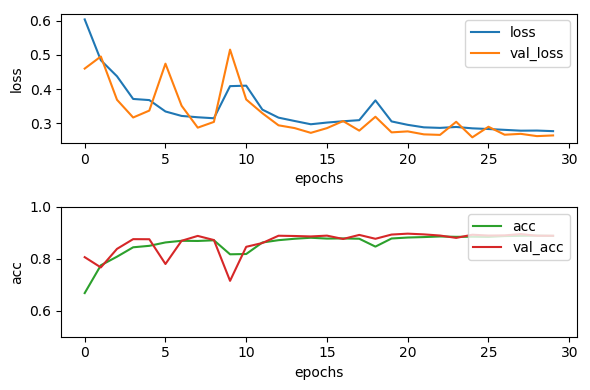

In [115]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

# Model \#5: Embedding + Conv1D + Pooling + LSTM (poor)

In [116]:
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(3, 2))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 927, 64)           20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 463, 64)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [117]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/30
25925/25925 [==============================] - 20s 784us/step - loss: 0.5094 - acc: 0.7498 - val_loss: 0.4164 - val_acc: 0.8150
Epoch 2/30
25925/25925 [==============================] - 18s 693us/step - loss: 0.3572 - acc: 0.8537 - val_loss: 0.3362 - val_acc: 0.8629
Epoch 3/30
25925/25925 [==============================] - 18s 676us/step - loss: 0.3262 - acc: 0.8672 - val_loss: 0.3719 - val_acc: 0.8507
Epoch 4/30
25925/25925 [==============================] - 18s 678us/step - loss: 0.3080 - acc: 0.8754 - val_loss: 0.3049 - val_acc: 0.8754
Epoch 5/30
25925/25925 [==============================] - 18s 676us/step - loss: 0.2968 - acc: 0.8808 - val_loss: 0.2917 - val_acc: 0.8886
Epoch 6/30
25925/25925 [==============================] - 18s 675us/step - loss: 0.2933 - acc: 0.8837 - val_loss: 0.2641 - val_acc: 0.8938
Epoch 7/30
25925/25925 [==============================] - 17s 675us/step - loss: 0.2873 - acc: 0.8843 - val_loss: 0.3

# Model \#7: Embedding + BiLSTM

In [131]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 26,241
Trainable params: 26,241
Non-trainable params: 0
_________________________________________________________________


In [132]:
callbacks = [EarlyStopping(monitor='val_loss', patience=30)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/500
25925/25925 [==============================] - 43s 2ms/step - loss: 0.5792 - acc: 0.7071 - val_loss: 0.5119 - val_acc: 0.7459
Epoch 2/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4919 - acc: 0.7771 - val_loss: 0.4728 - val_acc: 0.7858
Epoch 3/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4799 - acc: 0.7858 - val_loss: 0.5178 - val_acc: 0.7463
Epoch 4/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4752 - acc: 0.7882 - val_loss: 0.4803 - val_acc: 0.7876
Epoch 5/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4301 - acc: 0.8157 - val_loss: 0.5322 - val_acc: 0.7362
Epoch 6/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4497 - acc: 0.7945 - val_loss: 0.3950 - val_acc: 0.8393
Epoch 7/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.4059 - acc: 0.8275 - val_loss: 0.3790 - v

25925/25925 [==============================] - 42s 2ms/step - loss: 0.2491 - acc: 0.8977 - val_loss: 0.2514 - val_acc: 0.8924
Epoch 60/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2485 - acc: 0.8975 - val_loss: 0.2478 - val_acc: 0.8921
Epoch 61/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2472 - acc: 0.8986 - val_loss: 0.2458 - val_acc: 0.8948
Epoch 62/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2499 - acc: 0.8968 - val_loss: 0.2487 - val_acc: 0.8924
Epoch 63/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2474 - acc: 0.9000 - val_loss: 0.2460 - val_acc: 0.8962
Epoch 64/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2470 - acc: 0.8981 - val_loss: 0.2441 - val_acc: 0.9000
Epoch 65/500
25925/25925 [==============================] - 42s 2ms/step - loss: 0.2448 - acc: 0.9011 - val_loss: 0.2480 - val_acc: 0.8910
Epoch 66/500
25925/25925 [==============

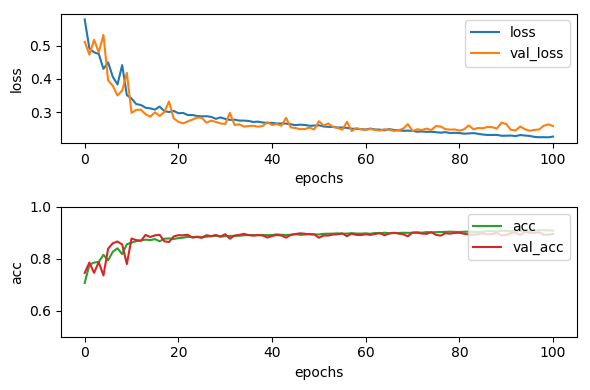

In [134]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('embedding_bilstm.png')

In [135]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

28806/28806 [==============================] - 69s 2ms/step
test_loss: 0.2656 - test_acc: 0.8942


In [136]:
model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [178]:
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-5, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 922, 128)          82048     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 918, 128)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/500
25925/25925 [==============================] - 59s 2ms/step - loss: 0.6904 - acc: 0.5388 - val_loss: 0.6869 - val_acc: 0.5783
Epoch 2/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.6833 - acc: 0.5978 - val_loss: 0.6795 - val_acc: 0.6272
Epoch 3/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.6749 - acc: 0.6265 - val_loss: 0.6696 - val_acc: 0.6335
Epoch 4/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.6633 - acc: 0.6351 - val_loss: 0.6550 - val_acc: 0.6397
Epoch 5/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.6439 - acc: 0.6545 - val_loss: 0.6279 - val_acc: 0.6654
Epoch 6/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.6011 - acc: 0.6937 - val_loss: 0.5695 - val_acc: 0.7241
Epoch 7/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.5620 - acc: 0.7336 - val_loss: 0.5524 - v

25925/25925 [==============================] - 57s 2ms/step - loss: 0.4834 - acc: 0.7951 - val_loss: 0.4764 - val_acc: 0.7987
Epoch 60/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.4539 - acc: 0.8139 - val_loss: 0.4534 - val_acc: 0.8146
Epoch 61/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.4436 - acc: 0.8199 - val_loss: 0.4502 - val_acc: 0.8074
Epoch 62/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.4286 - acc: 0.8257 - val_loss: 0.4344 - val_acc: 0.8219
Epoch 63/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.4277 - acc: 0.8231 - val_loss: 0.4283 - val_acc: 0.8237
Epoch 64/500
25925/25925 [==============================] - 58s 2ms/step - loss: 0.4218 - acc: 0.8243 - val_loss: 0.4253 - val_acc: 0.8258
Epoch 65/500
25925/25925 [==============================] - 57s 2ms/step - loss: 0.4407 - acc: 0.8148 - val_loss: 0.4289 - val_acc: 0.8199
Epoch 66/500
25925/25925 [==============

In [ ]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('embedding_conv_bilstm.png')

# Model \#9: Embedding + Conv1D + Dense

In [169]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 931, 64)           1088      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 927, 64)           20544     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 923, 64)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 923, 64)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 59072)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 59073     
Total params: 80,705
Trainable params: 80,705
Non-trainable params: 0
_________________________________________________________________


In [171]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] ## TODO

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 25925 samples, validate on 2881 samples
Epoch 1/100
25925/25925 [==============================] - 9s 356us/step - loss: 0.1814 - acc: 0.9273 - val_loss: 0.4176 - val_acc: 0.8660
Epoch 2/100
25925/25925 [==============================] - 9s 354us/step - loss: 0.1806 - acc: 0.9284 - val_loss: 0.3588 - val_acc: 0.8653
Epoch 3/100
25925/25925 [==============================] - 9s 354us/step - loss: 0.1755 - acc: 0.9311 - val_loss: 0.4312 - val_acc: 0.8410
Epoch 4/100
25925/25925 [==============================] - 9s 355us/step - loss: 0.1800 - acc: 0.9310 - val_loss: 0.3747 - val_acc: 0.8702
Epoch 5/100
25925/25925 [==============================] - 9s 354us/step - loss: 0.1699 - acc: 0.9326 - val_loss: 0.3816 - val_acc: 0.8695
Epoch 6/100
25925/25925 [==============================] - 9s 354us/step - loss: 0.1656 - acc: 0.9350 - val_loss: 0.3786 - val_acc: 0.8632
Epoch 7/100
25925/25925 [==============================] - 9s 355us/step - loss: 0.1614 - acc: 0.9372 - val_loss: 0.4

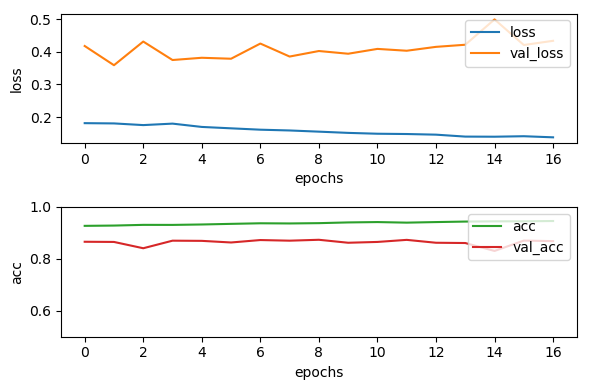

In [172]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('embedding_conv_dropout_dense.png')

In [173]:
model.save_weights('embedding_conv_dropout_dense.png')

# Try masking...